In [1]:
import torch 
import torch.nn as nn
import lightning as L
from glob import glob

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from BalticRiverPrediction.convLSTM import ConvLSTM

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet, LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, EnhancedMSELoss, EnhancedMSEMetric, PredictionPlottingCallback

from utility import loadData, PredictionData

In [2]:
data, runoff = loadData()

In [3]:
modelParameters = {
"input_dim": 4,
"hidden_dim": 9,
"kernel_size": (7,7),
"num_layers": 1,
"batch_first": True,
"bias": True,
"return_all_layers": False,
"dimensions": (222,244),
"input_size": 30
}

pyTorchBaltNet = BaltNet(modelPar=modelParameters)

LightningBaltNet = LightningModel.load_from_checkpoint(
# checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive2TopOne-v2.ckpt",
checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/TrainCoupledModelMoreSensitive3TopOne-v2.ckpt",
learning_rate=1e-3,
map_location="cpu",
model=pyTorchBaltNet,
cosine_t_max=100
)

In [21]:
# Used for the scaling of the NN prediction 
dataDataset = AtmosphericDataset(
    atmosphericData=data.sel(time=slice("1979", "2011")),
    runoff=runoff.sel(time=slice("1979", "2011")),
    input_size=modelParameters["input_size"],
)

dataLoader = AtmosphereDataModule(
    atmosphericData=data.sel(time=slice("1979", "2011")),
    runoff=runoff.sel(time=slice("1979", "2011")),
    batch_size=50,
    input_size=modelParameters["input_size"],
    num_workers=16
)

In [22]:
dataLoader.setup(stage="")

In [23]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
predictions = trainer.predict(LightningBaltNet, dataloaders=dataLoader.test_dataloader())

You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [25]:
testData = np.zeros((len(dataLoader.test), 97))
iterater = iter(dataLoader.test)
for i in range(len(dataLoader.test)):
    batch = next(iterater)[1]
    testData[i,:] = batch
    

In [26]:
concatenated_predictions = torch.cat(predictions, dim=0) # concat in time
rescaledRunoffData = concatenated_predictions*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data
rescaledTestData = testData*dataLoader.runoffDataStats[1].data+dataLoader.runoffDataStats[0].data

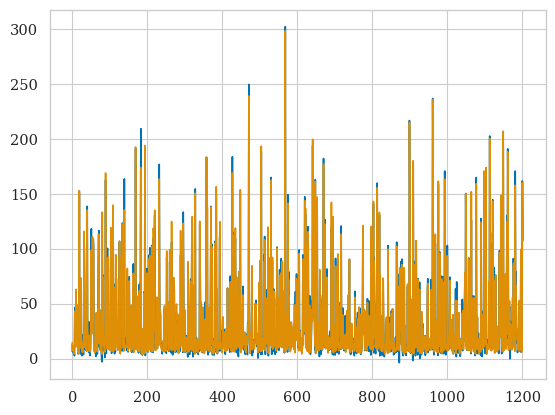

In [27]:
plt.plot(rescaledRunoffData[:,0])
plt.plot(rescaledTestData[:,0])

In [28]:
runoffData = xr.Dataset(
    {
        "prediction":(("time", "river"), rescaledRunoffData),
        "original":(("time","river"), rescaledTestData)
    },
    coords={
        "time": np.arange(len(rescaledRunoffData)),
        "river":np.arange(97)
    }
)

/tmp/ipykernel_734/972340759.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


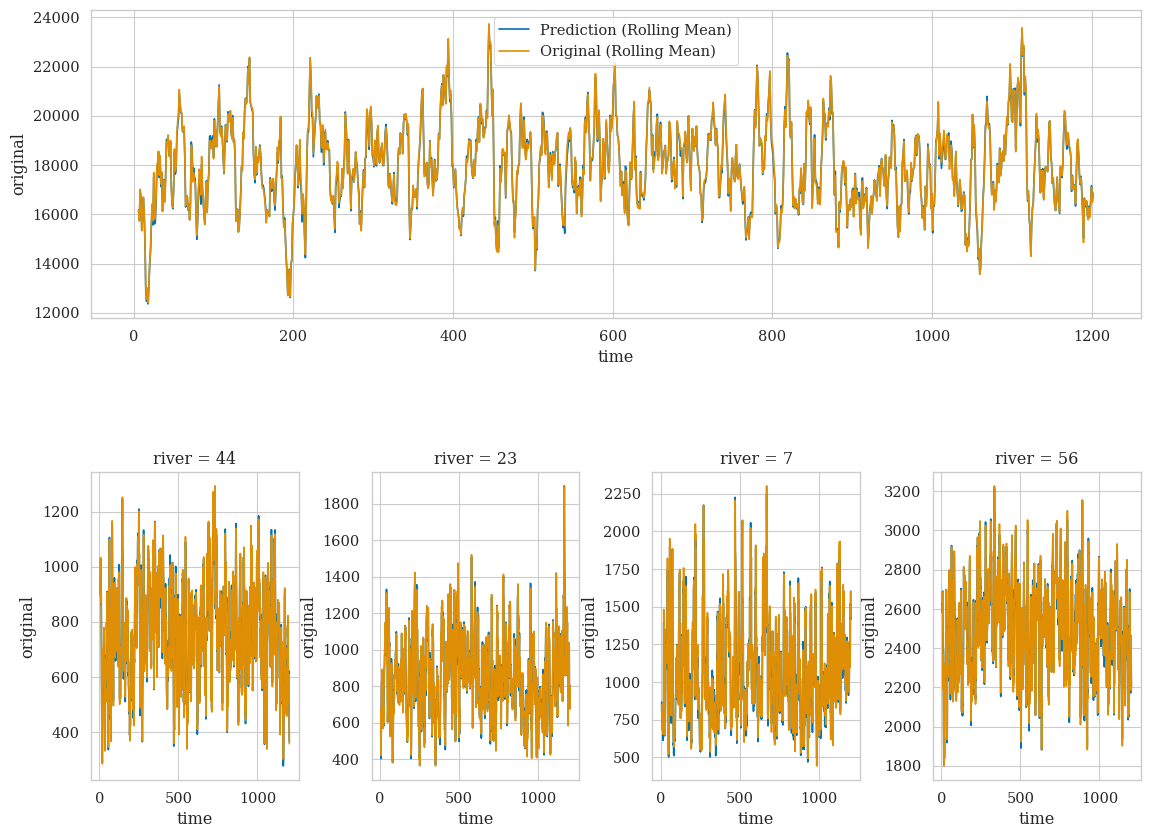

In [29]:
rolling_window_size = 7

# Top Plot: Sum over all rivers and calculate rolling mean

fig = plt.figure(figsize=(15, 10))

gs = fig.add_gridspec(nrows=2, ncols=4, left=0.05, right=0.75,
                      hspace=0.5, wspace=0.35)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[1, 3])
axes = [ax1, ax2, ax3, ax4]

(runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean()).plot(ax=ax0, label='Prediction (Rolling Mean)')
(runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean()).plot(ax=ax0, label='Original (Rolling Mean)')
plt.title('Total river runoff Baltic Sea')
ax0.legend()

sum_over_time = runoffData.sum(dim='time')
largest_rivers = sum_over_time.to_array().sum(dim='variable').argsort()[-4:]

for i, river in enumerate(largest_rivers.values):
    (runoffData.sel(river=river)['prediction'].rolling(time=rolling_window_size).mean()).plot(ax=axes[i], label='Prediction')
    (runoffData.sel(river=river)['original'].rolling(time=rolling_window_size).mean()).plot(ax=axes[i], label='Original')
   # axes[i].legend()

plt.tight_layout()

In [46]:
largest_rivers

<xarray.DataArray (river: 4)>
array([44, 23,  7, 56])
Coordinates:
  * river    (river) int64 93 94 95 96

/tmp/ipykernel_734/2460400215.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


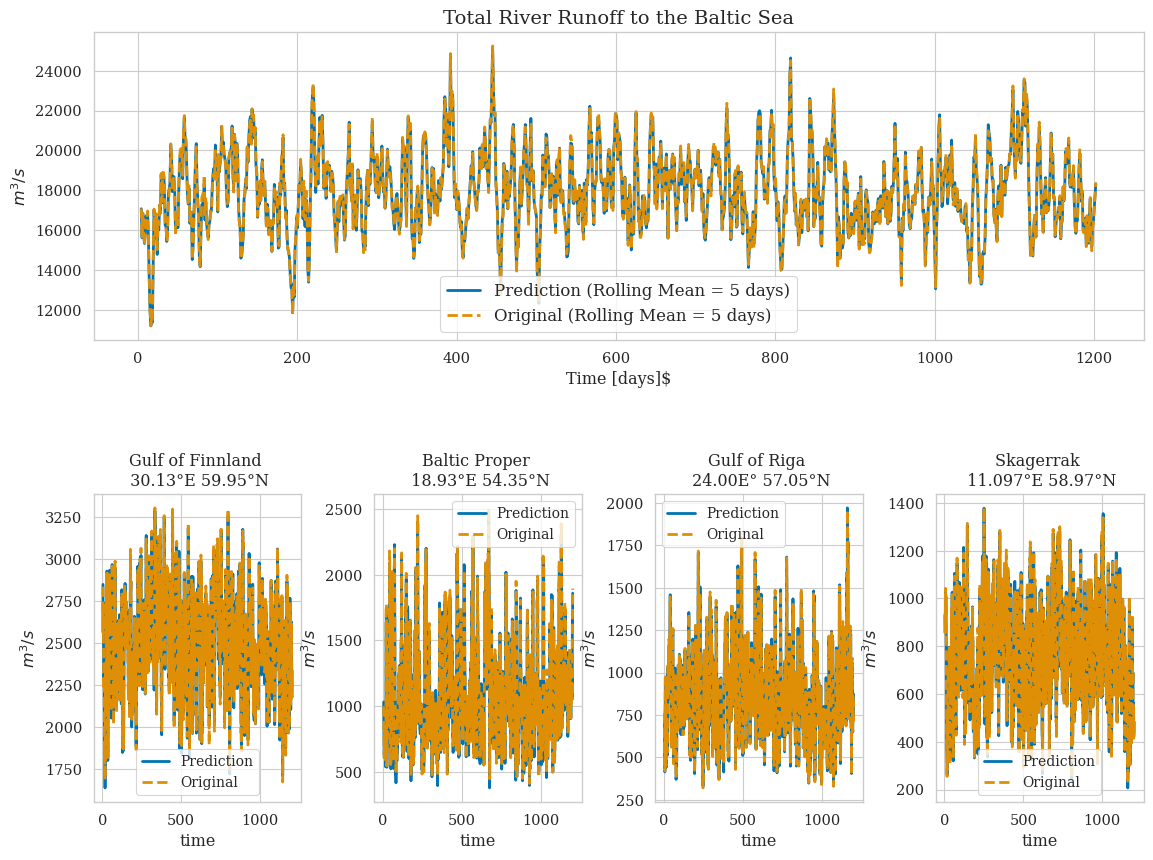

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn for better default visual styles
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)

rolling_window_size = 5
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(nrows=2, ncols=4, left=0.05, right=0.75, hspace=0.5, wspace=0.35)

ax0 = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[1, i]) for i in range(4)]

# Plot rolling means with improved aesthetics
runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().plot(ax=ax0, label=f'Prediction (Rolling Mean = {rolling_window_size} days)', linewidth=2)
runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean().plot(ax=ax0, label=f'Original (Rolling Mean = {rolling_window_size} days)', linewidth=2, linestyle='--')
ax0.set_title('Total River Runoff to the Baltic Sea', fontsize=14)
ax0.set_ylabel("$m^3/s$")
ax0.set_xlabel("Time [days]$")

ax0.legend(fontsize=12)

# Adjustments for individual river plots
largest_rivers = runoffData.sum(dim='time').to_array().sum(dim='variable').argsort()[::-1][0:4]
for i, river in enumerate(largest_rivers.values):
    runoffData.sel(river=river)['prediction'].rolling(time=rolling_window_size).mean().plot(ax=axes[i], label='Prediction', linewidth=2)
    runoffData.sel(river=river)['original'].rolling(time=rolling_window_size).mean().plot(ax=axes[i], label='Original', linewidth=2, linestyle='--')
    #axes[i].set_title(f'River {i+1}', fontsize=12)
    axes[i].legend(fontsize=10)
    axes[i].set_ylabel("$m^3/s$")

axes[3].set_title("Skagerrak \n 11.097°E 58.97°N")
axes[2].set_title("Gulf of Riga \n 24.00E° 57.05°N")
axes[1].set_title("Baltic Proper \n 18.93°E 54.35°N")
axes[0].set_title("Gulf of Finnland \n 30.13°E 59.95°N")

fig.tight_layout()
fig.savefig("figures/paper_total_river_runoff.png", dpi=300)

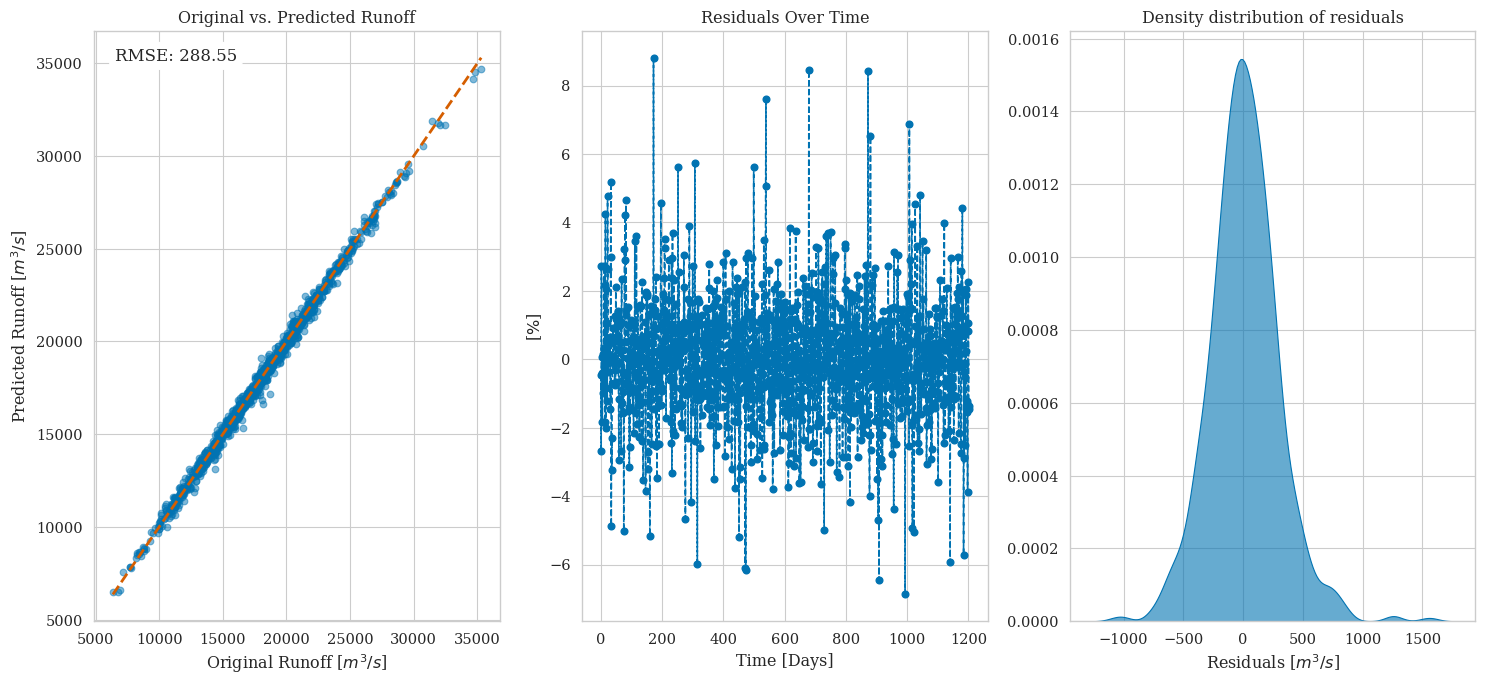

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming 'runoffData' has dimensions [time, river] for both 'prediction' and 'original'
def calculate_rmse(original, prediction):
    return np.sqrt(np.mean((original - prediction) ** 2))

rolling_window_size = 1

# Sum over all rivers and calculate rolling mean
summed_pred = runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')
summed_orig = runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')

# Calculate RMSE for the summed rolling mean data
rmse_val = calculate_rmse(summed_orig, summed_pred)

# Plotting
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

# Scatter plot with 1:1 line
ax1.scatter(summed_orig, summed_pred, alpha=0.5)
ax1.plot([summed_orig.min(), summed_orig.max()], [summed_orig.min(), summed_orig.max()], 'r--', lw=2)
ax1.set_xlabel('Original Runoff [$m^3/s$]')
ax1.set_ylabel('Predicted Runoff [$m^3/s$]')
ax1.set_title('Original vs. Predicted Runoff')
ax1.annotate(f'RMSE: {rmse_val:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             bbox=dict(boxstyle="round", fc="w"))

# Residual plot
residuals = summed_orig - summed_pred
residualsPct = residuals/summed_orig*100

ax2.plot(summed_orig.time.values, residualsPct, marker='o', linestyle='--')
ax2.set_xlabel('Time [Days]')
ax2.set_ylabel('[$\%$]')
ax2.set_title('Residuals Over Time')

sns.kdeplot(residuals, alpha=0.6, ax = ax3, fill=True)
#sns.kdeplot(runoffData.sum("river").to_dataframe()["prediction"], alpha=0.6, ax = ax3, fill=True)
ax3.set_xlabel('Residuals [$m^3/s$]')
ax3.set_ylabel('')

ax3.set_title('Density distribution of residuals')

plt.tight_layout()

plt.savefig("figures/paper_error_metrics.png", dpi=300)

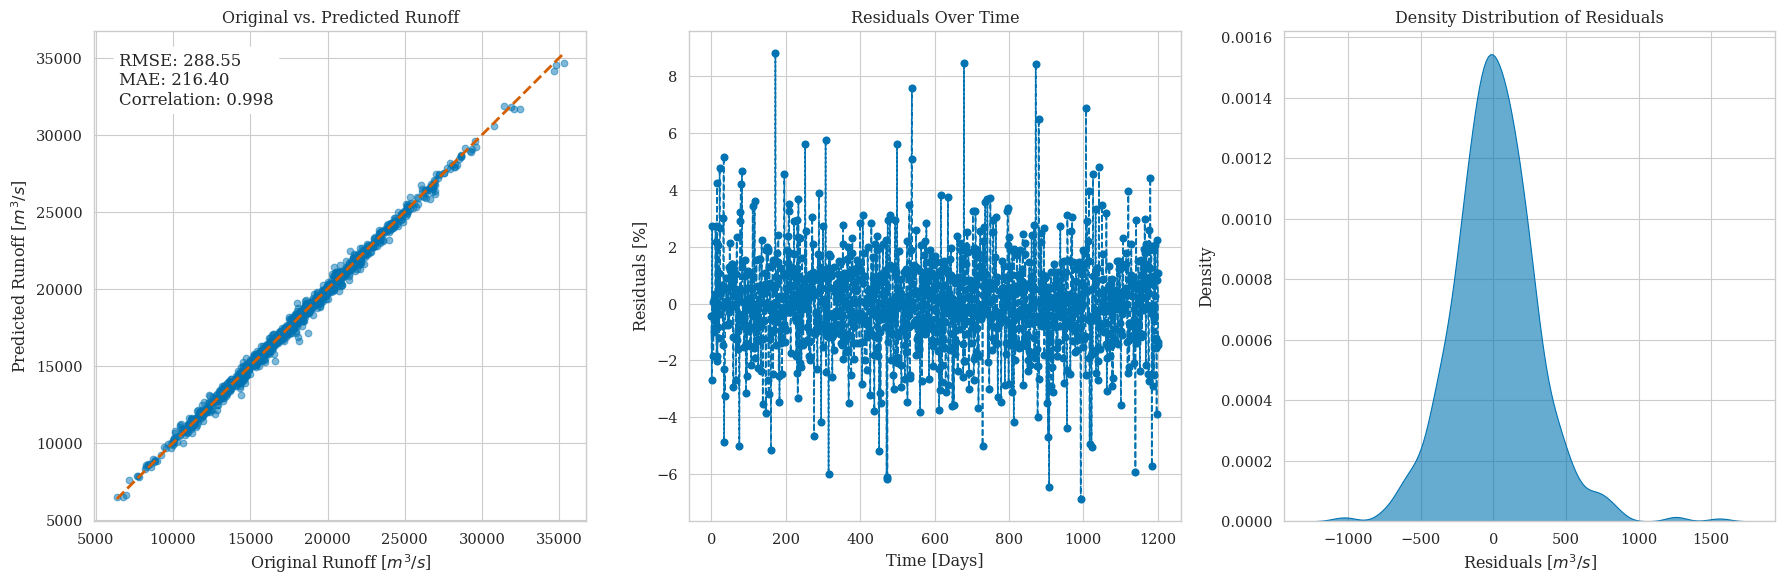

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Assuming 'runoffData' and 'rolling_window_size' are defined
# Placeholder for 'runoffData' structure, replace with your actual data loading logic

def calculate_rmse(original, prediction):
    return np.sqrt(np.mean((original - prediction) ** 2))

def calculate_mae(original, prediction):
    return np.mean(np.abs(original - prediction))

def calculate_correlation(original, prediction):
    corr, _ = pearsonr(original, prediction)
    return corr

# Sum over all rivers and calculate rolling mean
summed_pred = runoffData['prediction'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')
summed_orig = runoffData['original'].sum(dim='river').rolling(time=rolling_window_size).mean().dropna('time')

# Calculate metrics
rmse_val = calculate_rmse(summed_orig, summed_pred)
mae_val = calculate_mae(summed_orig, summed_pred)
correlation_val = calculate_correlation(summed_orig, summed_pred)

# Plotting
sns.set_theme(context='paper', style='whitegrid', palette='colorblind', font='DejaVu Serif', font_scale=1.2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot with 1:1 line
ax1.scatter(summed_orig, summed_pred, alpha=0.5)
ax1.plot([summed_orig.min(), summed_orig.max()], [summed_orig.min(), summed_orig.max()], 'r--', lw=2)
ax1.set_xlabel('Original Runoff [$m^3/s$]')
ax1.set_ylabel('Predicted Runoff [$m^3/s$]')
ax1.set_title('Original vs. Predicted Runoff')
metrics_text = f'RMSE: {rmse_val:.2f}\nMAE: {mae_val:.2f}\nCorrelation: {correlation_val:.3f}'
ax1.annotate(metrics_text, xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12, bbox=dict(boxstyle="round", fc="w"))

# Residual plot
residuals = summed_orig - summed_pred
residualsPct = residuals / summed_orig * 100
ax2.plot(summed_orig.time.values, residualsPct, marker='o', linestyle='--')
ax2.set_xlabel('Time [Days]')
ax2.set_ylabel('Residuals [$\%$]')
ax2.set_title('Residuals Over Time')

# Density plot for residuals
sns.kdeplot(residuals, alpha=0.6, ax=ax3, fill=True)
ax3.set_xlabel('Residuals [$m^3/s$]')
ax3.set_title('Density Distribution of Residuals')

fig.tight_layout()
fig.savefig("figures/paper_error_metrics.png", dpi=300)